### Load Libraries

In [199]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline #To compact necessary steps at once
from sklearn.preprocessing import StandardScaler #For Scaling
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor



### Import the Data
The housing data

In [200]:

import os
import tarfile
from urllib.request import urlretrieve  # Direct import for modern Python versions

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    """Fetch and extract housing data from the given URL."""
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    
    tgz_path = os.path.join(housing_path, "housing.tgz")
    
    try:
        print("Downloading housing data...")
        urlretrieve(housing_url, tgz_path)
        print("Download complete.")
    except Exception as e:
        print(f"An error occurred while downloading the data: {e}")
        return
    
    try:
        print("Extracting housing data...")
        with tarfile.open(tgz_path) as housing_tgz:
            housing_tgz.extractall(path=housing_path)
        print("Extraction complete.")
    except Exception as e:
        print(f"An error occurred while extracting the data: {e}")

# To run the function
fetch_housing_data()


Download complete.
Extracting housing data...
Extraction complete.


### Loading the dataset

In [201]:
def load_housing_data(housing_path=HOUSING_PATH):
    """Load housing data from a CSV file."""
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

# Example usage
if __name__ == "__main__":
    # Ensure that the data is fetched and extracted before loading
    fetch_housing_data()  # Ensure this function is defined and working
    housing_data = load_housing_data()
    print(housing_data.head())


Download complete.
Extracting housing data...
Extraction complete.
   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY  


### Data Exploration

* Are there missing values?
* Are there correlations?
* Checking more particularly for the Label or dependent variable
* Are some general variables better when checked individually or in combination with other attributes?
* Is there a need for normalisation especially for visually skewed attributes?
* Is it necessary to stratify numeric data, especially if it will be useful for labelling?

In [202]:
housing_data.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


In [203]:
#housing_id = housing_data.reset_index()
#housing_data['index_id'] = housing_data.index

In [204]:
housing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


##### Shows they all have 20640 rows except for total bedrooms, indicating possible missing values. Also, all the columns are numeric except for ocean_proximity which indicates, possible categorical data


##### Checking for Numeric Data

In [205]:
housing_data["ocean_proximity"].unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

In [206]:
housing_data.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [207]:
#Numeric data checks
housing_data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


##### Checking the Categorical data

In [208]:
#Categorical data checks
housing_data['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

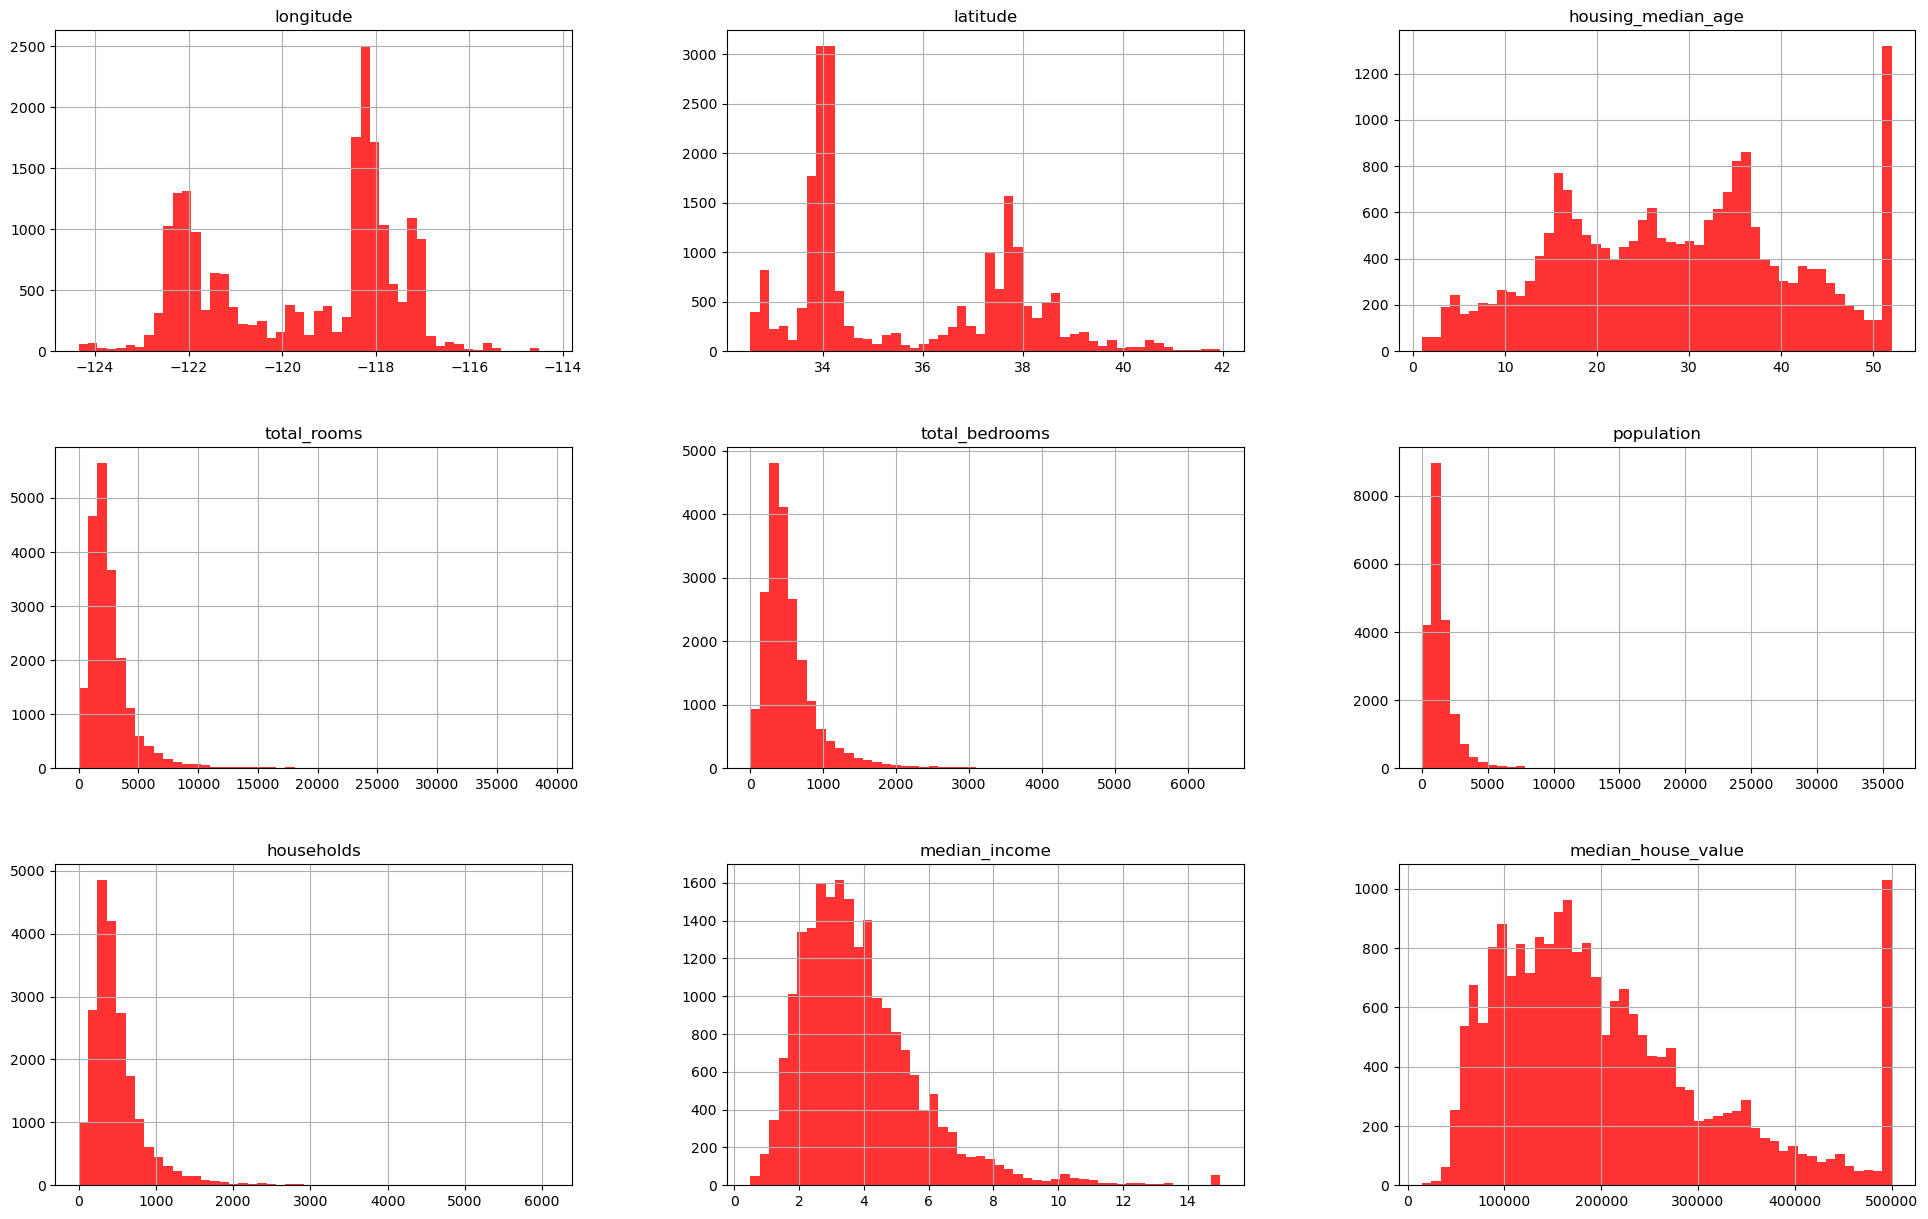

In [209]:
housing_data.hist(bins=50, figsize=(24,15), color="red", alpha = 0.8)
plt.show()

##### Visualizing latitude and longitude correlation

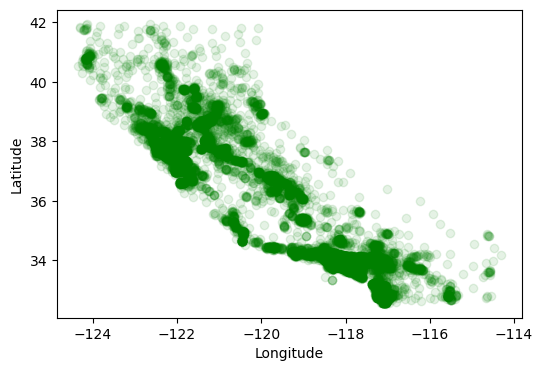

In [210]:
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(housing_data["longitude"], housing_data["latitude"], color = 'green', alpha=0.1)
ax.set_ylabel("Latitude")
ax.set_xlabel("Longitude")
plt.show()

### Checking for Correlations between Features

In [211]:
# Selecting only numeric columns for correlation matrix
numeric_housing_data = housing_data.select_dtypes(include=[float, int])
#Works for Numeric variables, so we filter numeric variables out using .select_dtypes

corr_matrix = numeric_housing_data.corr()

# Display correlation of each attribute with median_house_value
print(corr_matrix["median_house_value"].sort_values(ascending=False))

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64


## Machine Learning Preparation


In [212]:
X = housing_data.drop("median_house_value", axis=1).copy()

In [213]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   ocean_proximity     20640 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.4+ MB


In [214]:
y = housing_data["median_house_value"].copy()
##### Copy out the label data from the general dataset

#### Missing Data

In [215]:
# Define Median from dataset
#median = X["total_bedrooms"].median() 
#imputer = SimpleImputer(strategy="median")

##### Categorical data needs to be dropped before applying SimpleImputer to feature with missing data

In [216]:
#drop categorical attribute to input median for missing values
X_num = X.drop("ocean_proximity", axis=1)

In [217]:
X_num

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462
...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672


#### SimpleImputer for Handling Missing value


##### fit method: This computes the statistics (median values) needed to fill in the missing values for each column.

In [218]:
#to fit the median directly in the data where there are missing values
#imputer.fit(X_num)

In [219]:
#imputer.statistics_

In [220]:
#Personal checking of the median of each attribute
#X.describe() #50% shows and confirms the same values computed by simpleimputer

In [221]:
#x = imputer.transform(X_num)
#x[:5]

The result is a plain NumPy array containing the transformed features. To change the dataset back to Pandas DataFrame

In [222]:
#housing_tr = pd.DataFrame(x, columns=X_num.columns)
#housing_tr.isnull().sum() #Now there are no missing data

### Handling Text and Categorical Attributes 
Most Machine Learning algorithms prefer to work with numbers, so we convert these categories from text to numbers. 

In [223]:
#housing_cat = X[["ocean_proximity"]]

#### Using One-hot Encoding to convert categoricary to numeric value that machine learning can use

In [224]:
# Create OneHotEncoder instance
#cat_encoder = OneHotEncoder()

# Fit and transform the data
#housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

In [225]:
# Convert to array for better readability
#housing_cat_1hot_array = housing_cat_1hot.toarray()

# Display the result
#print(housing_cat_1hot_array)

After one- hot encoding we get a matrix with thousands of columns, and the matrix is full of zeros except for a single 1 per row. If a categorical attribute has a large number of possible categories (e.g., country code, profession, species, etc.), then one-hot encoding will result in a large number of input features. This may slow down training and degrade performance. 

In [226]:
#cat_encoder.categories_

####
Feature Scaling
Using Standardization

In [227]:
#num_pipeline = Pipeline([('imputer', SimpleImputer(strategy="median")),  # Handle missing values
#                         ('std_scaler', StandardScaler()),]) # Standardize features

#training_num_tr = num_pipeline.fit_transform(X_num) #Transform fit data to an array
#training_num_tr

## ColumnTransformer
To preprocess both numerical and categorical features at once instead of individually as specified above, this ColumnTransformer pipeline fills missing values with the median for numeric data, applies one-hot encoding for categorical data, and then performs feature scaling to normalize the values.

In [228]:
number_attrib = list(X_num.columns) 
category_attribs = ["ocean_proximity"]

# Define the numerical and categorical pipelines
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),  # Handle missing values
    ('std_scaler', StandardScaler())  # Standardize features
])

# Full pipeline with ColumnTransformer
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, number_attrib), 
    ("cat", OneHotEncoder(), category_attribs)
])

# Apply the full pipeline to the data 
X_cleaned = full_pipeline.fit_transform(X)

In [229]:
X_cleaned

array([[-1.32783522,  1.05254828,  0.98214266, ...,  0.        ,
         1.        ,  0.        ],
       [-1.32284391,  1.04318455, -0.60701891, ...,  0.        ,
         1.        ,  0.        ],
       [-1.33282653,  1.03850269,  1.85618152, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.8237132 ,  1.77823747, -0.92485123, ...,  0.        ,
         0.        ,  0.        ],
       [-0.87362627,  1.77823747, -0.84539315, ...,  0.        ,
         0.        ,  0.        ],
       [-0.83369581,  1.75014627, -1.00430931, ...,  0.        ,
         0.        ,  0.        ]])

### Linear Regression Model

#### Scikit-Learn Design: Detailed Summary and Explanation
##### Major Steps
+ Instantiate with the Library object
+ Fit and Transform
+ Predict



In [230]:
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y, random_state=42)

In [231]:
#Instantiate the Model
linReg = LinearRegression()

In [232]:
#Train the Model
#The fit method trains the Linear Regression model on the provided data.
linReg.fit(X_train, y_train)

LinearRegression()

In [233]:
print("Coefficients:", linReg.coef_)

Coefficients: [-5.31785161e+04 -5.33228270e+04  1.38003281e+04 -1.30635569e+04
  4.44005701e+04 -4.31281298e+04  1.70208045e+04  7.46418173e+04
 -2.68630408e+17 -2.68630408e+17 -2.68630408e+17 -2.68630408e+17
 -2.68630408e+17]


In [234]:
print("Intercept:", linReg.intercept_)

Intercept: 2.6863040836577558e+17


**y = coefficients * x + 2.69**

In [235]:
test_house = X.iloc[:5] 
test_labels = y.iloc[:5]
test_predict= full_pipeline.transform(test_house)

In [236]:
print("Prediction:", linReg.predict(test_predict))

Prediction: [409344. 418816. 379072. 321344. 254880.]


In [237]:
print("Labels:", list(test_labels))

Labels: [452600.0, 358500.0, 352100.0, 341300.0, 342200.0]


Predictions seemed to be a little close

#### Calculating mean squared error
The mean_squared_error function is used to calculate the mean squared error (MSE) between the actual and predicted values.

In [238]:
from sklearn.metrics import mean_squared_error, r2_score

# Predict on the training set
predictions = linReg.predict(X_train)

# Calculate MSE
mse = mean_squared_error(y_train, predictions)
lin_rmse = np.sqrt(mse)
print("Mean Squared Error:", lin_rmse)


Mean Squared Error: 68611.32060219506


In [239]:
# Calculate R² Score
r2 = r2_score(y_train, predictions)
print("R² Score:", r2)

R² Score: 0.6471962191231917


In [240]:
# Create a DataFrame to display the results
results = pd.DataFrame({
    'Metric': ['Mean Squared Error', 'R² Score'],
    'Value': [lin_rmse, r2]
})
# Display the results table
print(results)


               Metric         Value
0  Mean Squared Error  68611.320602
1            R² Score      0.647196


High MSE of 68633.408108 suggests that there is a significant difference between the predicted and actual values. 
R² Score of 0.648099 means that approximately 64.72% of the variance in the target variable can be explained by the model. 

#### Trying another model- Decision Tree Regression

In [241]:
regTree = DecisionTreeRegressor()
regTree.fit(X_train, y_train)

DecisionTreeRegressor()

In [242]:
housing_predict = regTree.predict(X_train)
print(housing_predict)

[228500. 279900. 183000. ... 222100. 283500. 325000.]


In [243]:
tree_mse = mean_squared_error(y_train, housing_predict) 
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

#### Comparing linear regression and decision tree regression
Decision tree has a smaller value compared to linear regression but this shows its probably too fitting to the training data

### Decision tree Evaluation Using Cross-Validation

In [244]:
score_eval = cross_val_score(regTree,X_train, y_train, scoring="neg_mean_squared_error", cv=10)
# Convert scores to positive RMSE
rmse_scores = np.sqrt(-score_eval)

In [245]:
# Display the results
print("Cross-Validation RMSE Scores:", '\n', rmse_scores)
print("Mean RMSE:", '\n', rmse_scores.mean())
print("Standard Deviation:", '\n', rmse_scores.std())

Cross-Validation RMSE Scores: 
 [69126.16756364 72082.79527272 67801.37067885 67142.83033027
 71685.75258599 69871.46643112 65397.3613525  70872.68006884
 67931.1925783  66548.14089632]
Mean RMSE: 
 68845.97577585254
Standard Deviation: 
 2139.642977004283


The very large between training and cross-validation RMSE is a clear sign of overfitting. This is expected since there were no prior limitation to tree growth set, like pruning the tree which limits the maximum depth of the tree or sets a minimum number of samples required to split a node (min_samples_split)

#### Cross Validation for linear regression model

In [246]:
#AT ten-fold
lm_score = cross_val_score(linReg, housing_cleaned, housing_labels, scoring="neg_mean_squared_error", cv=10)
# Convert scores to positive RMSE
lmse_scores = np.sqrt(-lm_score)

In [247]:
# Display the results
print("Cross-Validation LMSE Scores:", '\n', lmse_scores)
print("Mean LMSE:", '\n', lmse_scores.mean())
print("Standard Deviation:", '\n', lmse_scores.std())

Cross-Validation LMSE Scores: 
 [8.56458558e+04 5.97110814e+04 8.80475888e+04 6.28385880e+04
 5.30515127e+15 6.96734145e+04 5.24805983e+04 9.16195064e+04
 7.81742252e+04 5.35139860e+04]
Mean LMSE: 
 530515127033216.9
Standard Deviation: 
 1591545380885749.2


The similarity between training MSE (68,611) and cross-validation MSE mean (69,116) suggests that the Linear Regresssion model generalizes reasonably well compared to the regression tree

Other further evaluation for the regression model includes: Ensemble Method (with Random forest), Hyperparameter Tuning
while for the linear Regression despite performing well with cross-validation still require further steps like Feature Engineering, regularization like Ridge (L2) or Lasso (L1), and Hyperparameter Tuning of alpha for L1 and L2